In [1]:
import numpy as np
from numpy import sort
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.feature_selection import SelectFromModel
from xgboost import XGBClassifier
from xgboost import plot_importance

#from sklearn.pipeline import Pipeline
#from sklearn.preprocessing import PolynomialFeatures
from sklearn import metrics
from sklearn.metrics import accuracy_score, roc_auc_score
%matplotlib inline

In [2]:
plt.rc("font", size=14)
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

#### Functions for later use

In [3]:
def training_errors(model, x_train, y_train): 
    #y_train_predicted = model.predict(x_train)
    
    train_accuracy = model.score(x_train, y_train)
    print('Training Accuracy =', train_accuracy)
    print('')
    return train_accuracy

In [4]:
def accuracy_confusion_mat(model, x_test, y_test, y_predicted):
    acc_score = model.score(x_test, y_test)
    confusion_matrix = metrics.confusion_matrix(y_test, y_predicted)
    
    total = np.sum(confusion_matrix)
    
    print('Total number of observations = ', total)
    #print('Accuracy = ', round(acc_score, 2))
    
    #print('\nConfusion Matrix:\n', confusion_matrix)

    return acc_score, confusion_matrix

In [5]:
def confusion_plt(confusion_matrix, acc_score):
    plt.figure( figsize = (3, 3))
    sns.heatmap(confusion_matrix, annot = True, fmt=".3f", linewidths = .5, square = True, cmap = 'Blues_r');
    plt.ylabel('Actual label');
    plt.xlabel('Predicted label');

    #acc_score = round(acc_score, 2)

    all_sample_title = 'Accuracy Score: {0}'.format(acc_score)
    plt.title(all_sample_title, size = 13)

In [6]:
def confusion_perc_plt(confusion_matrix, acc_score):
    total = np.sum(confusion_mat)
    perc_confusion_matrix = confusion_mat/total
    
    plt.figure( figsize = (3, 3))
    sns.heatmap(perc_confusion_matrix, annot = True, fmt=".3f", linewidths = .5, square = True, cmap = 'Blues_r');
    plt.ylabel('Actual label');
    plt.xlabel('Predicted label');

    acc_score = round(acc_score, 2)

    all_sample_title = 'Accuracy Score: {0}'.format(acc_score)
    plt.title(all_sample_title, size = 13)
    
    return total

In [7]:
def errors(confusion_matrix):
    TP = confusion_matrix[1, 1]
    TN = confusion_matrix[0, 0]
    FP = confusion_matrix[0, 1]
    FN = confusion_matrix[1, 0]
    print('\nTP =', TP, '\nTN =', TN, '\nFP =', FP, '\nFN =', FN)
    
    accuracy = (TP + TN)/(TP + TN + FP + FN)
    print('\nValidation Accuracy = ', accuracy)
        
    return TP, TN, FP, FN, accuracy

In [8]:
def precision_recall(TP, TN, FP, FN):
    diagnosed_as_survived = TP + FP
    really_survived = TP + FN

    # among all cases that were found positive, what a % of actual positive cases
    precision = TP/diagnosed_as_survived
    # percentage of the people who indeed survived out of all cases that the model classified as 'survived' 
    # ex., % of really sick people that the test diagnosted as sick. 
    # if you were diagnosted as ill, what is the chance that you are really ill

    # percentage of correctly diagnosted people
    recall = TP/really_survived
    
    print('Precision =', precision , '\nRecall =', recall)
    
    print('\n*Precision: among all cases that were found positive, what is the proportion of actual positive cases TP/(TP + FP)')
    print('*Recall: percentage of correctly diagnosted people among all survived TP/(TP + FN)')
    
    return precision, recall

In [9]:
def classifier_accuracy(model, x, y):
    # accuracy
    y_predicted = model.predict(x)
    acc = metrics.accuracy_score(y, y_predicted)
    return acc

#### Import the Data

In [10]:
data = pd.read_csv('C:\\Users\\Inna\\Desktop\\scripts\\Titanic\\train.csv', index_col=0)
data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Name        891 non-null object
Sex         891 non-null object
Age         714 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Ticket      891 non-null object
Fare        891 non-null float64
Cabin       204 non-null object
Embarked    889 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [12]:
# pclass 	Ticket class 	1 = 1st, 2 = 2nd, 3 = 3rd
# sibsp 	# of siblings / spouses aboard the Titanic
# parch 	# of parents / children aboard the Titanic

In [13]:
print('The dataset provides Titanic passengers’ information. It includes', data.shape[0], 
      'records and', data.shape[1], 'features')

The dataset provides Titanic passengers’ information. It includes 891 records and 11 features


In [14]:
print('The list of the features:', list(data.columns))

The list of the features: ['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']


#### Creating Dummy Variables 

#### Create dummy variables for sex (1 = female, 0 = male) and the port of embarktion (1 = C = Cherbourg, 2 = Q = Queenstown, 3 = S = Southampton)

In [15]:
data['Sex_num'] = data.Sex.map({'female':1, 'male':0})
# data['Embarked_num'] = data.Embarked.map({'C':1, 'Q':2, 'S':3})

In [16]:
# One-hot vectors for the port of emabarking: 
# 1. create vectors of zeros: 
data_len = len(data['Name'])
data['Cherbourg'] = pd.Series(np.zeros(data_len), index = data.index)
data['Queenstown'] = pd.Series(np.zeros(data_len), index = data.index)
data['Southampton'] = pd.Series(np.zeros(data_len), index = data.index)

# 2. encode the data into these vectors acording to the port of embarktion: 
data['Cherbourg'] = data['Cherbourg'].where(data['Embarked'] != 'C', 1)
data['Queenstown'] = data['Queenstown'].where(data['Embarked'] != 'Q', 1)
data['Southampton'] = data['Southampton'].where(data['Embarked'] != 'S', 1)

In [17]:
data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sex_num,Cherbourg,Queenstown,Southampton
PassengerId,,,,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0,0.0,0.0,1.0
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1,1.0,0.0,0.0
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1,0.0,0.0,1.0
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1,0.0,0.0,1.0
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0,0.0,0.0,1.0


In [18]:
print('The updated dataset provides Titanic passengers’ information. It includes', data.shape[0], 
      'records and', data.shape[1], 'features')
print('The updated list of the features:', list(data.columns))

The updated dataset provides Titanic passengers’ information. It includes 891 records and 15 features
The updated list of the features: ['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Sex_num', 'Cherbourg', 'Queenstown', 'Southampton']


#### Taking Care of Missing Values

In [19]:
# Missing Values 
missingV = data.isnull().sum()
missingV.percent = missingV/len(data)*100
missingV.percent

Survived        0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
Age            19.865320
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.000000
Cabin          77.104377
Embarked        0.224467
Sex_num         0.000000
Cherbourg       0.000000
Queenstown      0.000000
Southampton     0.000000
dtype: float64

Observations: 
Age - 20% missing values, Cabin num - 77% missing values. 

In [20]:
threshold1 = len(data)*0.7
data.dropna(axis = 1, thresh = threshold1, inplace = True) #removes features that have more than 70% missing values
data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Sex_num,Cherbourg,Queenstown,Southampton
PassengerId,,,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,0,0.0,0.0,1.0
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,1,1.0,0.0,0.0
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,1,0.0,0.0,1.0
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,1,0.0,0.0,1.0
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,0,0.0,0.0,1.0


Observations: Cabin feature has been removes since there are more than 70% missing values

#### Quick Data Exploration

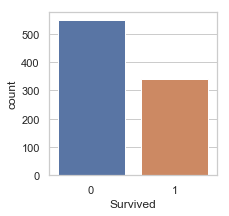

In [21]:
plt.figure(figsize = (3, 3))
sns.countplot(x = 'Survived', data = data)
plt.show()
# plt.savefig('Count Plot')

In [22]:
survivorsPerc = data.where(data['Survived'] == 1).count()[0] / len(data) * 100
print('Percentage of survivors is', int(survivorsPerc))
print('Percentage of victims is', 100-int(survivorsPerc))
print('The ratio of survivors to victims is', int(survivorsPerc), ':', 100-int(survivorsPerc))

Percentage of survivors is 38
Percentage of victims is 62
The ratio of survivors to victims is 38 : 62


Observations: 
Classes are slightly inbalanced

In [23]:
data.groupby('Survived').mean()

,Pclass,Age,SibSp,Parch,Fare,Sex_num,Cherbourg,Queenstown,Southampton
Survived,,,,,,,,,
0,2.531876,30.626179,0.553734,0.329690,22.117887,0.147541,0.136612,0.085610,0.777778
1,1.950292,28.343690,0.473684,0.464912,48.395408,0.681287,0.271930,0.087719,0.634503


In [24]:
data.groupby('Survived').count()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Sex_num,Cherbourg,Queenstown,Southampton
Survived,,,,,,,,,,,,,
0,549,549,549,424,549,549,549,549,549,549,549,549,549
1,342,342,342,290,342,342,342,342,340,342,342,342,342


#### Observations: 
1. Ticket class (Pclass) of survived is higher than vistims' class
2. Survivors' tickets were much more expensive than vistims' (Fare)
3. There is no substantial difference between the age of survivors and victims
4. Women had more chance to survive than men
5. classes are inballanced



In [25]:
data.groupby('SibSp').count()

,Survived,Pclass,Name,Sex,Age,Parch,Ticket,Fare,Embarked,Sex_num,Cherbourg,Queenstown,Southampton
SibSp,,,,,,,,,,,,,
0,608,608,608,608,471,608,608,608,606,608,608,608,608
1,209,209,209,209,183,209,209,209,209,209,209,209,209
2,28,28,28,28,25,28,28,28,28,28,28,28,28
3,16,16,16,16,12,16,16,16,16,16,16,16,16
4,18,18,18,18,18,18,18,18,18,18,18,18,18
5,5,5,5,5,5,5,5,5,5,5,5,5,5
8,7,7,7,7,0,7,7,7,7,7,7,7,7


In [26]:
survivors = data.where(data.Survived == 1)
victims = data.where(data.Survived == 0)
#survivors.count()

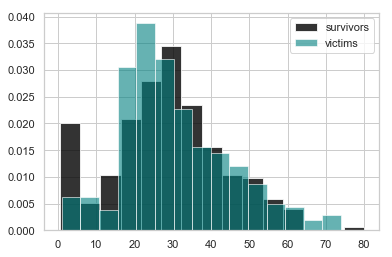

In [27]:
plt.figure(1)

survivors.Age.hist(bins = 15, color = 'black', density = True, alpha = 0.8)  
# density: normalization to form probability density, pdf
victims.Age.hist(bins = 15, color='teal', alpha = 0.6, density = True)  # alpha = transperancy
plt.legend(['survivors', 'victims'])


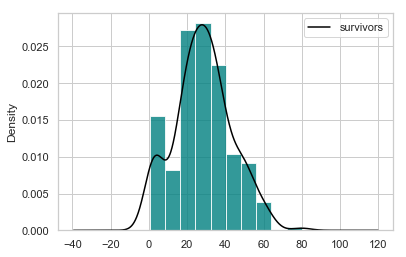

In [28]:
plt.figure(2)

survivors.Age.hist(bins = 10, color = 'teal', alpha = 0.8, density = True)
survivors.Age.plot(kind='density', color='black')
plt.legend(['survivors'])

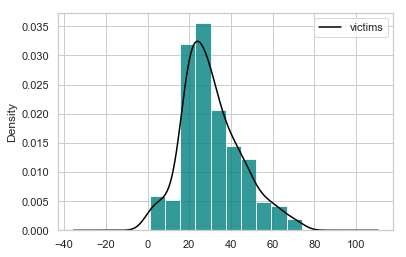

In [29]:
plt.figure(3)

victims.Age.hist(bins = 10, color = 'teal', alpha = 0.8, density = True)
victims.Age.plot(kind='density', color='black')
plt.legend(['victims'])

#### Preprocessing

#### Oversampling for balancing classes - creating synthetic observations

In [30]:
data2 = data.copy()

# Filling missing data
data2.fillna(data2.Age.median(),inplace = True)
#traindata.fillna(traindata.Embarked_num.mode(),inplace = True)

data2.isnull().sum()

Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
Sex_num        0
Cherbourg      0
Queenstown     0
Southampton    0
dtype: int64

In [31]:
corrs = data2.corr()
corrs

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_num,Cherbourg,Queenstown,Southampton
Survived,1.000000,-0.338481,-0.064910,-0.035322,0.081629,0.257307,0.543351,0.168240,0.003650,-0.155660
Pclass,-0.338481,1.000000,-0.339898,0.083081,0.018443,-0.549500,-0.131900,-0.243292,0.221009,0.081720
Age,-0.064910,-0.339898,1.000000,-0.233296,-0.172482,0.096688,-0.081163,0.030248,-0.031415,-0.014665
SibSp,-0.035322,0.083081,-0.233296,1.000000,0.414838,0.159651,0.114631,-0.059528,-0.026354,0.070941
Parch,0.081629,0.018443,-0.172482,0.414838,1.000000,0.216225,0.245489,-0.011069,-0.081228,0.063036
Fare,0.257307,-0.549500,0.096688,0.159651,0.216225,1.000000,0.182333,0.269335,-0.117216,-0.166603
Sex_num,0.543351,-0.131900,-0.081163,0.114631,0.245489,0.182333,1.000000,0.082853,0.074115,-0.125722
Cherbourg,0.168240,-0.243292,0.030248,-0.059528,-0.011069,0.269335,0.082853,1.000000,-0.148258,-0.778359
Queenstown,0.003650,0.221009,-0.031415,-0.026354,-0.081228,-0.117216,0.074115,-0.148258,1.000000,-0.496624
Southampton,-0.155660,0.081720,-0.014665,0.070941,0.063036,-0.166603,-0.125722,-0.778359,-0.496624,1.000000


# Prediction Models

#### Hyperparameters

In [32]:
test_size = 0.2

#### Since there is a high collinearity between a Fare and a class ("Pclass"), we will include only the fare in the model. 

In [33]:
X = data2.loc[:, ['Age', 'SibSp', 'Parch', 'Fare', 'Sex_num', 'Cherbourg', 'Queenstown', 'Southampton']]
y = data2.loc[:, data2.columns == 'Survived']

In [34]:
X.head()

,Age,SibSp,Parch,Fare,Sex_num,Cherbourg,Queenstown,Southampton
PassengerId,,,,,,,,
1,22.0,1,0,7.2500,0,0.0,0.0,1.0
2,38.0,1,0,71.2833,1,1.0,0.0,0.0
3,26.0,0,0,7.9250,1,0.0,0.0,1.0
4,35.0,1,0,53.1000,1,0.0,0.0,1.0
5,35.0,0,0,8.0500,0,0.0,0.0,1.0


#### Cross-validation

In [35]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = test_size, random_state = 100)

### Model 1 - Decision Tree Classifier

In [36]:
# Hyperparameters
num_of_models = 18

In [37]:
param_dict = {'model_depth': [], 'train_accuracy': [], 'validation_accuracy': [], 'precision': [], 'recall': []}
param_dict

{'model_depth': [],
 'train_accuracy': [],
 'validation_accuracy': [],
 'precision': [],
 'recall': []}

In [38]:
for i in range(num_of_models): 
    
    depth = i + 1 
    
    # training the model with different max depth
    model = DecisionTreeClassifier(criterion = "entropy", random_state = 27,
                               max_depth = depth, min_samples_leaf = 5, min_samples_split = 10).fit(x_train, y_train)
    #print(model)
    # train accuracy
    #train_acc1 = model.score(x_train, y_train)
    y_predicted_train = model.predict(x_train)
    train_acc = metrics.accuracy_score(y_train, y_predicted_train)

    # test accuracy
    #validation_acc = model.score(x_test, y_test)
    y_predicted_test = model.predict(x_test)
    validation_acc = metrics.accuracy_score(y_test, y_predicted_test)
        
    # precision and recall calculations: 
    confusion_matrix = metrics.confusion_matrix(y_test, y_predicted_test)
    TP = confusion_matrix[1, 1]
    TN = confusion_matrix[0, 0]
    FP = confusion_matrix[0, 1]
    FN = confusion_matrix[1, 0]

    precision = TP/(TP + FP)
    recall = TP/(TP + FN)
    
    # appending the results to the dict: 
    param_dict['model_depth'].append(depth)
    param_dict['train_accuracy'].append(train_acc)
    param_dict['validation_accuracy'].append(validation_acc)
    param_dict['precision'].append(precision)
    param_dict['recall'].append(recall)

    
param_dict_df = pd.DataFrame(data = param_dict)

In [39]:
param_dict_df

,model_depth,train_accuracy,validation_accuracy,precision,recall
0,1,0.786517,0.787709,0.768116,0.706667
1,2,0.786517,0.787709,0.768116,0.706667
2,3,0.810393,0.815642,0.808824,0.733333
3,4,0.820225,0.804469,0.777778,0.746667
4,5,0.820225,0.804469,0.777778,0.746667
5,6,0.824438,0.782123,0.764706,0.693333
6,7,0.834270,0.804469,0.777778,0.746667
7,8,0.845506,0.821229,0.802817,0.760000
8,9,0.846910,0.810056,0.780822,0.760000
9,10,0.855337,0.804469,0.803030,0.706667


#### Models' Accuracy as a Function of its Complexity

Text(0.5, 1.0, "Accuracy as a Function of Model's Complexity")

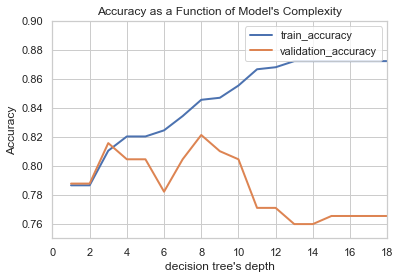

In [40]:
plt.figure()

plt.plot(param_dict_df.model_depth, param_dict_df.train_accuracy, linewidth = 2)
plt.plot(param_dict_df.model_depth, param_dict_df.validation_accuracy, linewidth = 2)
#plt.plot('train_accuracy', 'validation_accuracy', data = param_dict_df)
plt.xlim(0, num_of_models)
plt.ylim(0.75, 0.9)
plt.legend()
plt.xlabel("decision tree's depth")
plt.ylabel("Accuracy")
plt.title("Accuracy as a Function of Model's Complexity")

Text(0.5, 1.0, "Precision and Recall as a Function of Model's Complexity")

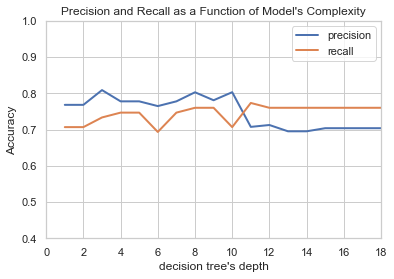

In [41]:
plt.figure()

plt.plot(param_dict_df.model_depth, param_dict_df.precision, linewidth = 2)
plt.plot(param_dict_df.model_depth, param_dict_df.recall, linewidth = 2)
plt.xlim(0, num_of_models)
plt.ylim(0.4, 1)
plt.legend()
plt.xlabel("decision tree's depth")
plt.ylabel("Accuracy")
plt.title("Precision and Recall as a Function of Model's Complexity")

Text(0.5, 1.0, "Accuracy as a Function of Model's Complexity")

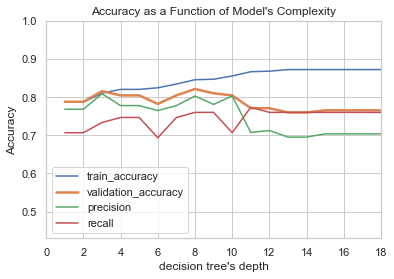

In [42]:
plt.figure()
plt.plot(param_dict_df.model_depth, param_dict_df.train_accuracy, linewidth = 1.5)
plt.plot(param_dict_df.model_depth, param_dict_df.validation_accuracy, linewidth = 2.5)
plt.plot(param_dict_df.model_depth, param_dict_df.precision, linewidth = 1.5)
plt.plot(param_dict_df.model_depth, param_dict_df.recall, linewidth = 1.5)
plt.xlim(0, num_of_models)
plt.ylim(0.43, 1)
plt.legend()
plt.xlabel("decision tree's depth")
plt.ylabel("Accuracy")
plt.title("Accuracy as a Function of Model's Complexity")

In [43]:
max_validation_acc = param_dict_df.validation_accuracy.max()
best_model_params = param_dict_df.loc[param_dict_df.validation_accuracy == max_validation_acc]
best_model_complexity = best_model_params.model_depth.max()
best_model_params
best_model_complexity.max()

8

In [44]:
max_recall = param_dict_df.loc[param_dict_df.recall == param_dict_df.recall.max()]
#max_recall.iloc[0, 0]
max_recall

,model_depth,train_accuracy,validation_accuracy,precision,recall
10,11,0.866573,0.77095,0.707317,0.773333


#### The best model

In [45]:
best_model = DecisionTreeClassifier(criterion = "entropy", random_state = 100,
                               max_depth = best_model_complexity, min_samples_leaf = 5, 
                                    min_samples_split = 10).fit(x_train, y_train)

Training Accuracy = 0.8455056179775281

Total number of observations =  179

TP = 57 
TN = 90 
FP = 14 
FN = 18

Validation Accuracy =  0.8212290502793296
Precision = 0.8028169014084507 
Recall = 0.76

*Precision: among all cases that were found positive, what is the proportion of actual positive cases TP/(TP + FP)
*Recall: percentage of correctly diagnosted people among all survived TP/(TP + FN)


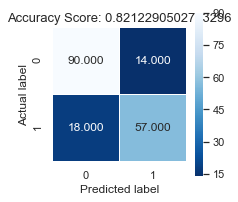

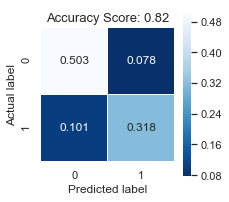

In [46]:
# Measuring Model Performance
y_predicted = best_model.predict(x_test)

training_errors(best_model, x_train, y_train)
[acc, confusion_mat] = accuracy_confusion_mat(best_model, x_test, y_test, y_predicted)
confusion_plt(confusion_mat, acc)
confusion_perc_plt(confusion_matrix, acc)
[TP, TN, FP, FN, accuracy] = errors(confusion_mat)
precision, recall = precision_recall(TP, TN, FP, FN)

In [47]:
best_model_params

,model_depth,train_accuracy,validation_accuracy,precision,recall
7,8,0.845506,0.821229,0.802817,0.76


In [48]:
F_score = metrics.f1_score(y_test, y_predicted)
F_score

0.7808219178082192

### Model 2 - basic XGBoost

In [49]:
model = XGBClassifier(learning_rate = 0.15, max_depth = 3, subsample = 0.6, colsample_bytree = 0.8, n_estimators = 200)
model.fit(x_train, y_train)

C:\Users\Inna\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Inna\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.15, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=200,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.6)

In [50]:
#print(model)

In [51]:
y_pred = model.predict(x_test)
accuracy = metrics.accuracy_score(y_test, y_predicted)
accuracy

0.8212290502793296

In [52]:
F_score = metrics.f1_score(y_test, y_predicted)
F_score

0.7808219178082192

#### or by my functions: 

In [53]:
train_accuracy = classifier_accuracy(model, x_train, y_train)
train_accuracy

0.9073033707865169

In [54]:
test_accuracy = classifier_accuracy(model, x_test, y_test)
test_accuracy

0.8212290502793296

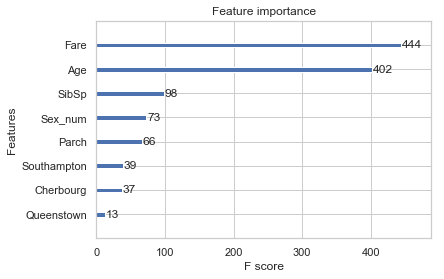

In [55]:
# plot feature importance
plot_importance(model)
plt.show()

### Model 3 - tuning xgoost's parameters

In [56]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import cross_validate, StratifiedKFold, GridSearchCV, KFold
from sklearn import metrics
#from sklearn import cross_validation, metrics   #Additional scklearn functions
#from sklearn.grid_search import GridSearchCV   #Perforing grid search

In [57]:
# Constant parameters
objective = 'binary:logistic'  # defines the loss function
seed = 27 # random number

In [58]:
# Changing parameters - initial values
max_depth = 5  # max depth of a tree 
min_child_weight = 1  # min sum of weights of all observations required in a child ?
gamma = 0  # A node is split only when the resulting split gives a positive reduction in the loss function. 
            # Gamma specifies the minimum loss reduction required to make a split.
subsample = 0.8  #  proportion of of obesrvations for eahc tree 
colsample_bytree = 0.8   # The number of features to consider while searching for a best split. 
            # as a thumb-rule, square root of the total number of features works great 
            # but we should check upto 30-40% of the total number of features.
scale_pos_weight = 1  # value greater than 0 should be used in case of high class imbalance
learning_rate = 0.1 
n_estimators = 1000  # the number of trees

In [59]:
model1 = XGBClassifier(learning_rate = learning_rate, n_estimators = n_estimators, max_depth = max_depth, min_child_weight = min_child_weight, 
 gamma = gamma, subsample = subsample, colsample_bytree = colsample_bytree, objective = objective, 
    scale_pos_weight = scale_pos_weight, seed = seed)

In [60]:
model1.get_xgb_params()

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bytree': 0.8,
 'gamma': 0,
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 5,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 1000,
 'nthread': 1,
 'objective': 'binary:logistic',
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': 27,
 'silent': True,
 'subsample': 0.8,
 'verbosity': 0}

### Step 1 - Find the best n_estimators (number of trees) by xgb.cv

In [61]:
# 1. convert the dataset into an optimized data structure called Dmatrix that XGBoost supports 
data_dmatrix = xgb.DMatrix(data = X, label = y)

In [62]:
xgb_param = model1.get_xgb_params()
num_boost_round = model1.get_params()['n_estimators']
num_boost_round

1000

In [63]:
# 2. cross-validation by xgboost
cvresult = xgb.cv(dtrain = data_dmatrix, params = xgb_param, nfold = 5,
                    num_boost_round = num_boost_round, early_stopping_rounds = 50, 
                    metrics = 'auc', as_pandas = True, seed = seed)

In [64]:
# cv_results contains train and test AUC metrics for each boosting round
cvresult.head()

,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
0,0.870352,0.005012,0.838552,0.014635
1,0.881144,0.005318,0.832970,0.013491
2,0.886954,0.004269,0.841522,0.015451
3,0.892013,0.005880,0.844403,0.011255
4,0.896029,0.004917,0.847403,0.008295


In [65]:
cvresult.tail()

,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
132,0.976934,0.002699,0.863429,0.015485
133,0.977168,0.002517,0.863992,0.015143
134,0.977345,0.002443,0.863945,0.015021
135,0.977501,0.002471,0.864236,0.014650
136,0.977631,0.002482,0.864349,0.014412


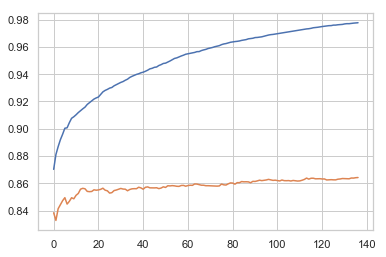

In [66]:
plt.plot(cvresult['train-auc-mean'])
plt.plot(cvresult['test-auc-mean'])

In [67]:
# Find the best number of estimators (trees), that is the number of iterations and update model's parameters: 
n_estimators = cvresult.shape[0]
model1.set_params(n_estimators = cvresult.shape[0])
n_estimators

137

In [68]:
model1.get_xgb_params()

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bytree': 0.8,
 'gamma': 0,
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 5,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 137,
 'nthread': 1,
 'objective': 'binary:logistic',
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': 27,
 'silent': True,
 'subsample': 0.8,
 'verbosity': 0}

In [69]:
# Model1 evaluation (accuracy & F-score)
accuracy = metrics.accuracy_score(y_test, y_predicted)
F_score = metrics.f1_score(y_test, y_predicted)
print('The test accuracy & the F-score:', round(accuracy, 4), '&', round(F_score, 4))

The test accuracy & the F-score: 0.8212 & 0.7808


In [70]:
# Measuring Model Performance
#y_predicted = model1.predict(x_test)

#training_errors(model1, x_train, y_train)
#[acc, confusion_mat] = accuracy_confusion_mat(model1, x_test, y_test, y_predicted)
#confusion_plt(confusion_mat, acc)
#confusion_perc_plt(confusion_matrix, acc)
#[TP, TN, FP, FN, accuracy] = errors(confusion_mat)
#precision, recall = precision_recall(TP, TN, FP, FN)

### Step 2: Tune max_depth and min_child_weight

In [71]:
# update xgb_param
xgb_param = model1.get_xgb_params()
#xgb_param

In [72]:
print(model1)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=137,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27, silent=True,
       subsample=0.8)


In [73]:
# Define parameters that we are going to test
test_params = {
 'max_depth':range(3, 8, 1), 
    'min_child_weight':range(1,6,2)
}

In [74]:
# GridSearchCV
grid_search1 = GridSearchCV(estimator = model1, 
                            param_grid = test_params, scoring = 'roc_auc', n_jobs = 4, iid = False, cv = 5)

In [75]:
grid_search1.fit(x_train, y_train)

C:\Users\Inna\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Inna\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=137,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27, silent=True,
       subsample=0.8),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'max_depth': range(3, 8), 'min_child_weight': range(1, 6, 2)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [76]:
grid_search1_df = pd.DataFrame(data = grid_search1.cv_results_)
grid_search1_df

C:\Users\Inna\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\Inna\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\Inna\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\Inna\Anaconda3\lib\site-packages\sklearn\utils\de

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_child_weight,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.980576,0.372488,0.010572,0.005801,3,1,"{'max_depth': 3, 'min_child_weight': 1}",0.833958,0.862672,0.859657,...,0.848145,0.048645,15,0.953197,0.946543,0.947706,0.938005,0.952004,0.947491,0.005364
1,0.208043,0.012797,0.006184,0.001465,3,3,"{'max_depth': 3, 'min_child_weight': 3}",0.836246,0.864024,0.862307,...,0.851862,0.053714,13,0.939725,0.934239,0.936719,0.926179,0.939587,0.935290,0.004986
2,0.210836,0.014908,0.005984,0.000631,3,5,"{'max_depth': 3, 'min_child_weight': 5}",0.830212,0.867561,0.852343,...,0.854352,0.048050,12,0.928153,0.921909,0.925424,0.912075,0.931646,0.923841,0.006696
3,0.242750,0.004910,0.006982,0.002092,4,1,"{'max_depth': 4, 'min_child_weight': 1}",0.826259,0.872451,0.862943,...,0.851784,0.044284,14,0.972695,0.968422,0.968766,0.964395,0.973242,0.969504,0.003224
4,0.262297,0.032999,0.007381,0.001850,4,3,"{'max_depth': 4, 'min_child_weight': 3}",0.835206,0.870058,0.860611,...,0.854366,0.048567,11,0.955030,0.951542,0.950462,0.944726,0.955411,0.951434,0.003865
5,0.364426,0.029496,0.007581,0.001954,4,5,"{'max_depth': 4, 'min_child_weight': 5}",0.839159,0.870474,0.856265,...,0.857784,0.047308,6,0.942093,0.937965,0.936798,0.929303,0.942193,0.937670,0.004709
6,0.319145,0.026030,0.015359,0.009241,5,1,"{'max_depth': 5, 'min_child_weight': 1}",0.832293,0.871827,0.868031,...,0.855664,0.037799,9,0.981623,0.982309,0.980495,0.980002,0.985437,0.981973,0.001913
7,0.350661,0.030529,0.009376,0.002571,5,3,"{'max_depth': 5, 'min_child_weight': 3}",0.840824,0.872555,0.856795,...,0.857431,0.045182,7,0.964756,0.961367,0.961330,0.955804,0.965662,0.961784,0.003464
8,0.285437,0.031026,0.007181,0.000746,5,5,"{'max_depth': 5, 'min_child_weight': 5}",0.838951,0.867769,0.859021,...,0.857795,0.043336,5,0.947064,0.944526,0.944588,0.937697,0.947614,0.944298,0.003531
9,0.310568,0.013971,0.011370,0.003602,6,1,"{'max_depth': 6, 'min_child_weight': 1}",0.830212,0.873908,0.867607,...,0.854901,0.036932,10,0.988665,0.988190,0.985896,0.986841,0.990858,0.988090,0.001696


In [77]:
grid_search1.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=7, min_child_weight=5, missing=None, n_estimators=137,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27, silent=True,
       subsample=0.8)

In [78]:
grid_search1.best_index_, grid_search1.best_params_, grid_search1.best_score_, grid_search1.scorer_ 

(14,
 {'max_depth': 7, 'min_child_weight': 5},
 0.8616309016245417,
 make_scorer(roc_auc_score, needs_threshold=True))

In [79]:
# Update model1's parameters

model1.set_params(max_depth = grid_search1.best_params_['max_depth'], 
                  min_child_weight = grid_search1.best_params_['min_child_weight'])

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=7, min_child_weight=5, missing=None, n_estimators=137,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27, silent=True,
       subsample=0.8)

In [80]:
# Fit the algorithm on the data
model1.fit(x_train, y_train)
y_predicted = model1.predict(x_test)

C:\Users\Inna\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Inna\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [81]:
# Model1 evaluation (accuracy & F-score)
accuracy = metrics.accuracy_score(y_test, y_predicted)
F_score = metrics.f1_score(y_test, y_predicted)
print('The test accuracy & the F-score:', round(accuracy, 4), '&', round(F_score, 4))

The test accuracy & the F-score: 0.8212 & 0.7746


### Step 3: Tune gamma

In [82]:
test_params = {
 'gamma':[i/10.0 for i in range(0,5)]
}

In [83]:
# GridSearchCV
grid_search2 = GridSearchCV(estimator = model1, 
                            param_grid = test_params, scoring = 'roc_auc', n_jobs = 4, iid = False, cv = 5)

In [84]:
grid_search2.fit(x_train, y_train)

C:\Users\Inna\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Inna\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=7, min_child_weight=5, missing=None, n_estimators=137,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27, silent=True,
       subsample=0.8),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'gamma': [0.0, 0.1, 0.2, 0.3, 0.4]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [85]:
grid_search2_df = pd.DataFrame(data = grid_search2.cv_results_)
#grid_search2_df

C:\Users\Inna\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\Inna\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\Inna\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\Inna\Anaconda3\lib\site-packages\sklearn\utils\de

In [86]:
grid_search2.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0.0, learning_rate=0.1,
       max_delta_step=0, max_depth=7, min_child_weight=5, missing=None,
       n_estimators=137, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=27, silent=True,
       subsample=0.8)

In [87]:
grid_search2.best_index_, grid_search2.best_params_, grid_search2.best_score_, grid_search2.scorer_ 

(0,
 {'gamma': 0.0},
 0.8616309016245417,
 make_scorer(roc_auc_score, needs_threshold=True))

In [88]:
# Update model1's parameters
model1.set_params(gamma = grid_search2.best_params_['gamma'])

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0.0, learning_rate=0.1,
       max_delta_step=0, max_depth=7, min_child_weight=5, missing=None,
       n_estimators=137, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=27, silent=True,
       subsample=0.8)

In [89]:
# Fit the algorithm on the data
model1.fit(x_train, y_train)
y_predicted = model1.predict(x_test)

C:\Users\Inna\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Inna\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [90]:
# Model1 evaluation (accuracy & F-score)
accuracy = metrics.accuracy_score(y_test, y_predicted)
F_score = metrics.f1_score(y_test, y_predicted)
print('The test accuracy & the F-score:', round(accuracy, 4), '&', round(F_score, 4))

The test accuracy & the F-score: 0.8212 & 0.7746


#### Re-calibrate the number of boosting rounds for the updated parameters
Again, find the best number of trees for current parameters: 

In [91]:
model1.set_params(n_estimators = 1000)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0.0, learning_rate=0.1,
       max_delta_step=0, max_depth=7, min_child_weight=5, missing=None,
       n_estimators=1000, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=27, silent=True,
       subsample=0.8)

In [92]:
# Update xgb_param
xgb_param = model1.get_xgb_params()
num_boost_round = model1.get_params()['n_estimators']
num_boost_round

1000

In [93]:
# 2. cross-validation by xgboost
cvresult = xgb.cv(dtrain = data_dmatrix, params = xgb_param, nfold = 5,
                    num_boost_round = num_boost_round, early_stopping_rounds = 50, 
                    metrics = 'auc', as_pandas = True, seed = seed)

In [94]:
# cv_results contains train and test AUC metrics for each boosting round
cvresult.tail()

,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
252,0.965834,0.002153,0.868534,0.009283
253,0.965938,0.002161,0.868877,0.009099
254,0.965965,0.002207,0.868749,0.008826
255,0.966068,0.002241,0.868650,0.008723
256,0.966242,0.002175,0.869275,0.008998


In [95]:
# Find the best number of estimators (trees), that is the number of iterations and update model's parameters: 
n_estimators = cvresult.shape[0]
model1.set_params(n_estimators = cvresult.shape[0])
n_estimators

257

In [96]:
model1.get_xgb_params()

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bytree': 0.8,
 'gamma': 0.0,
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 7,
 'min_child_weight': 5,
 'missing': None,
 'n_estimators': 257,
 'nthread': 1,
 'objective': 'binary:logistic',
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': 27,
 'silent': True,
 'subsample': 0.8,
 'verbosity': 0}

In [97]:
# Model's evaluation
model1.fit(x_train, y_train)
y_predicted = model1.predict(x_test)

accuracy = metrics.accuracy_score(y_test, y_predicted)
F_score = metrics.f1_score(y_test, y_predicted)
print('The test accuracy & the F-score:', round(accuracy, 4), '&', round(F_score, 4))

C:\Users\Inna\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Inna\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


The test accuracy & the F-score: 0.8045 & 0.7586


#### Step 4: Tune subsample and colsample_bytree

In [98]:
test_params = {
 'subsample':[i/10.0 for i in range(6, 10)],
 'colsample_bytree':[i/10.0 for i in range(6, 10)]
}

# GridSearchCV
grid_search3 = GridSearchCV(estimator = model1, 
                            param_grid = test_params, scoring = 'roc_auc', n_jobs = 4, iid = False, cv = 5)

In [99]:
grid_search3.fit(x_train, y_train)

C:\Users\Inna\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Inna\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0.0, learning_rate=0.1,
       max_delta_step=0, max_depth=7, min_child_weight=5, missing=None,
       n_estimators=257, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=27, silent=True,
       subsample=0.8),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'subsample': [0.6, 0.7, 0.8, 0.9], 'colsample_bytree': [0.6, 0.7, 0.8, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [100]:
grid_search3_df = pd.DataFrame(data = grid_search3.cv_results_)
#grid_search3_df

C:\Users\Inna\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\Inna\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\Inna\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\Inna\Anaconda3\lib\site-packages\sklearn\utils\de

In [101]:
grid_search3.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.7, gamma=0.0, learning_rate=0.1,
       max_delta_step=0, max_depth=7, min_child_weight=5, missing=None,
       n_estimators=257, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=27, silent=True,
       subsample=0.9)

In [102]:
grid_search3.best_index_, grid_search3.best_params_, grid_search3.best_score_, grid_search3.scorer_ 

(7,
 {'colsample_bytree': 0.7, 'subsample': 0.9},
 0.864737866974458,
 make_scorer(roc_auc_score, needs_threshold=True))

In [103]:
# Update model1's parameters
model1.set_params(colsample_bytree = grid_search3.best_params_['colsample_bytree'], 
                  subsample = grid_search3.best_params_['subsample'])

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.7, gamma=0.0, learning_rate=0.1,
       max_delta_step=0, max_depth=7, min_child_weight=5, missing=None,
       n_estimators=257, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=27, silent=True,
       subsample=0.9)

In [104]:
# Model's evaluation
model1.fit(x_train, y_train)
y_predicted = model1.predict(x_test)

accuracy = metrics.accuracy_score(y_test, y_predicted)
F_score = metrics.f1_score(y_test, y_predicted)
print('The test accuracy & the F-score:', round(accuracy, 4), '&', round(F_score, 4))

C:\Users\Inna\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Inna\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


The test accuracy & the F-score: 0.8156 & 0.766


#### Step 5: Tuning Regularization Parameters

In [105]:
test_params = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
# GridSearchCV
grid_search4 = GridSearchCV(estimator = model1, 
                            param_grid = test_params, scoring = 'roc_auc', n_jobs = 4, iid = False, cv = 5)

In [106]:
grid_search4.fit(x_train, y_train)

C:\Users\Inna\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Inna\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.7, gamma=0.0, learning_rate=0.1,
       max_delta_step=0, max_depth=7, min_child_weight=5, missing=None,
       n_estimators=257, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=27, silent=True,
       subsample=0.9),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'reg_alpha': [1e-05, 0.01, 0.1, 1, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [107]:
grid_search4.best_index_, grid_search4.best_params_, grid_search4.best_score_, grid_search4.scorer_ 

(0,
 {'reg_alpha': 1e-05},
 0.864737866974458,
 make_scorer(roc_auc_score, needs_threshold=True))

In [108]:
# Update model1's parameters
model1.set_params(reg_alpha = grid_search4.best_params_['reg_alpha'])

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.7, gamma=0.0, learning_rate=0.1,
       max_delta_step=0, max_depth=7, min_child_weight=5, missing=None,
       n_estimators=257, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=1e-05,
       reg_lambda=1, scale_pos_weight=1, seed=27, silent=True,
       subsample=0.9)

In [109]:
# Model's evaluation
model1.fit(x_train, y_train)
y_predicted = model1.predict(x_test)

accuracy = metrics.accuracy_score(y_test, y_predicted)
F_score = metrics.f1_score(y_test, y_predicted)
print('The test accuracy & the F-score:', round(accuracy, 4), '&', round(F_score, 4))

C:\Users\Inna\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Inna\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


The test accuracy & the F-score: 0.8156 & 0.766


#### Step 6: Reducing Learning Rate

In [110]:
model1.set_params(learning_rate = 0.01, 
                  n_estimators = 5000)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.7, gamma=0.0, learning_rate=0.01,
       max_delta_step=0, max_depth=7, min_child_weight=5, missing=None,
       n_estimators=5000, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=1e-05,
       reg_lambda=1, scale_pos_weight=1, seed=27, silent=True,
       subsample=0.9)

In [111]:
# update xgb_param
xgb_param = model1.get_xgb_params()

In [112]:
#  cross-validation by xgboost
cvresult = xgb.cv(dtrain = data_dmatrix, params = xgb_param, nfold = 5,
                    num_boost_round = num_boost_round, early_stopping_rounds = 50, 
                    metrics = 'auc', as_pandas = True, seed = seed)

In [113]:
cvresult.tail()

,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
248,0.914167,0.004169,0.856972,0.008451
249,0.914174,0.004226,0.857052,0.008489
250,0.914314,0.004236,0.857186,0.008383
251,0.914351,0.004327,0.857268,0.008481
252,0.914364,0.004385,0.857295,0.008628


In [114]:
# Find the best number of estimators (trees), that is the number of iterations and update model's parameters: 
n_estimators = cvresult.shape[0]
model1.set_params(n_estimators = cvresult.shape[0])
n_estimators

253

In [115]:
# Model's evaluation
model1.fit(x_train, y_train)
y_predicted = model1.predict(x_test)

accuracy = metrics.accuracy_score(y_test, y_predicted)
F_score = metrics.f1_score(y_test, y_predicted)
print('The test accuracy & the F-score:', round(accuracy, 4), '&', round(F_score, 4))

C:\Users\Inna\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Inna\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


The test accuracy & the F-score: 0.8101 & 0.7536


#### temporary - KFold

In [116]:
kf = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 27)

In [117]:
kf.get_n_splits(X)

10

In [118]:
count = 0
for train_index, test_index in kf.split(X, y):
    #print("TRAIN:", train_index, "TEST:", test_index)
    x_train, x_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    count += 1
    #print(count)
    #print(x_train)